In [4]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.patches as mpatches
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

In [3]:
file_path = r'D:\3__Donders\July 2025\forAndreiTables\forAndrei\posttrialTimeOrdered\NoArtifact&TS\Epochs_OSBasic_Rat3_AllSDs_NoArtifact&TS_timeOrder.txt'
df = pd.read_csv(file_path, sep=r'\s{2,}', engine='python') # skipping the first 2 header lines

latent_states = df['Corresponding Trained State'][1:].astype(int).tolist()

# transition matrix
unique_states = sorted(set(latent_states))
n_states = len(unique_states)
state_to_index = {state: idx for idx, state in enumerate(unique_states)}
count_matrix = np.zeros((n_states, n_states), dtype=int)

for (from_state, to_state) in zip(latent_states[:-1], latent_states[1:]):
    i = state_to_index[from_state]
    j = state_to_index[to_state]
    count_matrix[i, j] += 1

# Normalize to get transition probabilities
transition_matrix = count_matrix / count_matrix.sum(axis=1, keepdims=True)
transition_df = pd.DataFrame(transition_matrix, index=unique_states, columns=unique_states)

In [5]:
file_path = r'D:\3__Donders\July 2025\forAndreiTables\forAndrei\posttrialTimeOrdered\NoArtifact&TS\States_OSBasic_Rat3_AllSDs_NoArtifact&TS_timeOrder.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()

# Find the index of the dashed separator line (the line full of dashes)
sep_index = None
for i, line in enumerate(lines):
    if set(line.strip()) == {'-'}:
        sep_index = i
        break

# excluding the dashed line
clean_lines = lines[:sep_index] + lines[sep_index + 1:]

# Joining these lines back into a string
clean_data = ''.join(clean_lines)
mapping_df = pd.read_csv(StringIO(clean_data), sep=r'\s+', engine='python')

state_col = [col for col in mapping_df.columns if 'Corresponding' in col][0]
stage_col = [col for col in mapping_df.columns if 'Stage' in col][0]

state_to_stage = dict(zip(mapping_df[state_col], mapping_df[stage_col]))


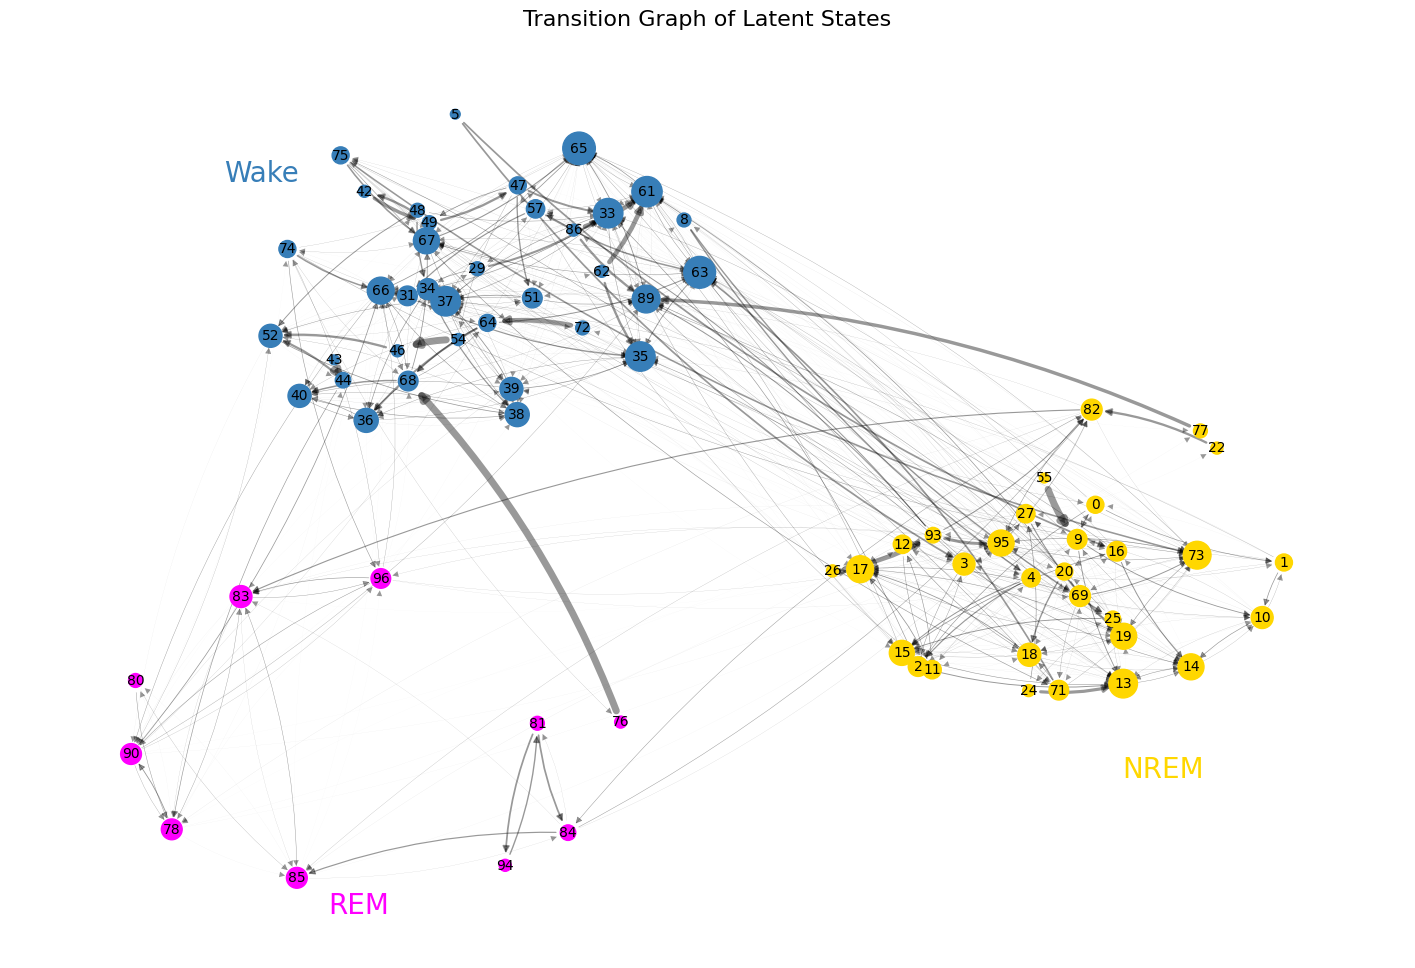

In [24]:
state_info = pd.DataFrame({
    'LatentStateID': list(state_to_stage.keys()),
    'MajoritySleepStage': list(state_to_stage.values())
})

# Map sleep stages to colors
stage_color_map = {
    'Wake': '#377eb8', 
    'NREM': 'gold',    
    'REM': 'magenta'    
}

G = nx.DiGraph()

# Add nodes with color attribute
for node in transition_df.index:
    if node in state_info['LatentStateID'].values:
        stage = state_info.loc[state_info['LatentStateID'] == node, 'MajoritySleepStage'].values[0]
        color = stage_color_map.get(stage, 'gray')
    else:
        stage = 'Unknown'
        color = 'gray'
    G.add_node(node, stage=stage, color=color)

# Prepare edges with threshold
all_probs = [
    transition_df.loc[from_node, to_node]
    for from_node in transition_df.index
    for to_node in transition_df.columns
    if from_node != to_node and transition_df.loc[from_node, to_node] > 0
]

threshold = np.percentile(all_probs, 20)

# Add edges above threshold
for from_node in transition_df.index:
    for to_node in transition_df.columns:
        prob = transition_df.loc[from_node, to_node]
        if prob > threshold and from_node != to_node:
            G.add_edge(from_node, to_node, weight=prob)

# Clusters by sleep stage
states = ['Wake', 'NREM', 'REM']
clusters = {s: [n for n, d in G.nodes(data=True) if d['stage'] == s] for s in states}

# Supergraph for cluster layout
superG = nx.Graph()
superG.add_nodes_from(states)
superG.add_edges_from([('Wake', 'NREM'), ('Wake', 'REM'), ('NREM', 'REM')])
centers = nx.spring_layout(superG, scale=8, seed=42)

# Spread nodes within clusters
pos = {}
for state in states:
    sub = G.subgraph(clusters[state])
    k_val = 1 / np.sqrt(len(sub.nodes)) if len(sub.nodes) > 0 else 0.1
    cpos = nx.spring_layout(
        sub,
        center=centers[state],
        scale=5,
        seed=42,
        k=k_val*10,
        iterations=200
    )
    pos.update(cpos)

# Node colors and sizes
node_colors_list = [G.nodes[n]['color'] for n in G.nodes()]
in_degrees = [G.in_degree(n) for n in G.nodes()]
min_deg = min(in_degrees) if in_degrees else 0
max_deg = max(in_degrees) if in_degrees else 1
scaled_node_sizes = [
    500 * ((deg - min_deg) / (max_deg - min_deg)) + 50 if max_deg != min_deg else 500
    for deg in in_degrees
]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Plotting
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_list, node_size=scaled_node_sizes)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='black',
    width=[w * 5 for w in edge_weights],
    arrows=True,
    connectionstyle='arc3,rad=0.1',
    alpha=0.4
)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Transition Graph of Latent States', fontsize=16)
plt.axis('off')
plt.text(centers['Wake'][0] - 4, centers['Wake'][1] + 3, 'Wake', fontsize=20, color=stage_color_map['Wake'], ha='center')
plt.text(centers['NREM'][0] + 2, centers['NREM'][1] - 6, 'NREM', fontsize=20, color=stage_color_map['NREM'], ha='center')
plt.text(centers['REM'][0], centers['REM'][1] - 5, 'REM', fontsize=20, color=stage_color_map['REM'], ha='center')
plt.show()

In [25]:
# Convert to undirected for Louvain algorithm
G_undirected = G.to_undirected()

# Perform Louvain community detection
partition = community_louvain.best_partition(G_undirected)

community_dict = {}
for node, com in partition.items():
    community_dict.setdefault(com, []).append(node)
print("Number of Communities:", len(community_dict))
print("Detected Meta-States (Communities):")
for com, nodes in community_dict.items():
    print(f"Meta-State {com}: {sorted(nodes)}")

Number of Communities: 11
Detected Meta-States (Communities):
Meta-State 0: [0, 29, 33, 34, 42, 47, 48, 49]
Meta-State 1: [1, 10, 11, 12, 17, 18, 19, 20, 26, 27, 31, 57, 69, 89, 93]
Meta-State 2: [2, 3, 4, 5, 8, 13, 14, 15, 16, 24, 25]
Meta-State 3: [9, 55]
Meta-State 5: [22, 66, 74, 77, 78, 80, 82, 83, 84, 85, 90, 95, 96]
Meta-State 6: [35, 61, 62, 86]
Meta-State 7: [36, 40, 64, 68, 72, 76]
Meta-State 8: [37, 39, 51, 63, 65, 67, 71, 73, 75]
Meta-State 9: [38, 46, 52, 54]
Meta-State 10: [43, 44]
Meta-State 4: [81, 94]


In [27]:
# Create mapping from latent state to meta-state
state_to_meta = {}
for meta_id, state_list in community_dict.items():
    for state in state_list:
        state_to_meta[state] = meta_id

# Create list of meta-state IDs
meta_states = sorted(community_dict.keys())

# Initialize new meta-state transition matrix
meta_transition = pd.DataFrame(0.0, index=meta_states, columns=meta_states)

# Aggregate transitions
for from_state in transition_df.index:
    for to_state in transition_df.columns:
        from_meta = state_to_meta.get(from_state)
        to_meta = state_to_meta.get(to_state)
        if from_meta is not None and to_meta is not None:
            meta_transition.loc[from_meta, to_meta] += transition_df.loc[from_state, to_state]

# Normalize each row 
meta_transition = meta_transition.div(meta_transition.sum(axis=1), axis=0)

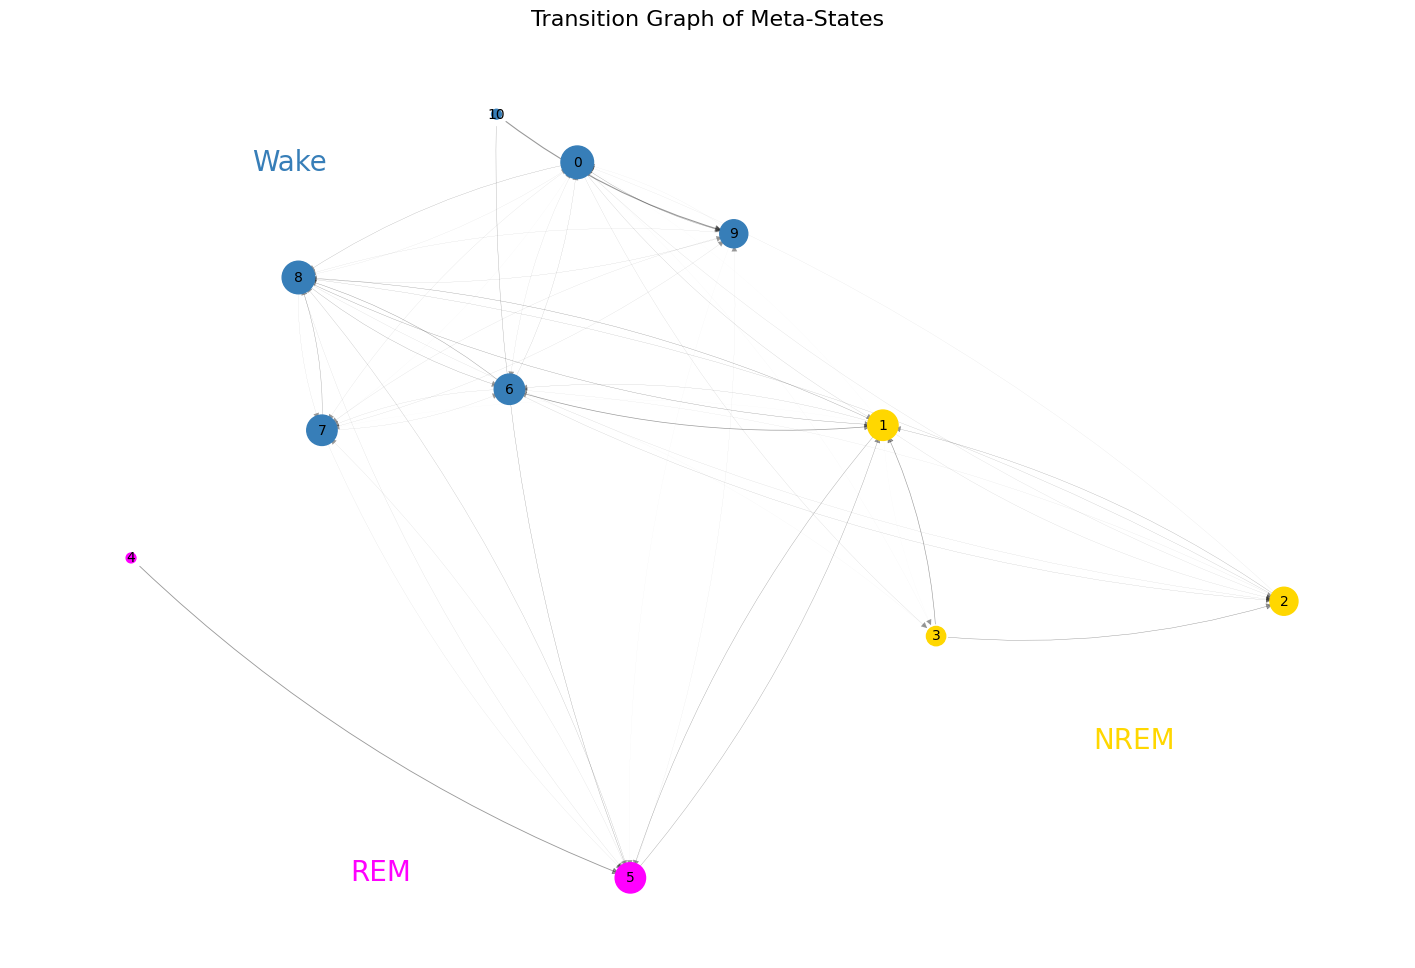

In [28]:
# === Map meta-state to majority sleep stage
meta_to_stage = {}
for meta_id, state_list in community_dict.items():
    stages = [state_to_stage[s] for s in state_list if s in state_to_stage]
    if stages:
        majority = pd.Series(stages).mode()[0]  # Use mode for majority
    else:
        majority = 'Unknown'
    meta_to_stage[meta_id] = majority

# === Build color map
stage_color_map = {
    'Wake': '#377eb8',   # blue
    'NREM': 'gold',      # yellow
    'REM': 'magenta',    # pink
    'Unknown': 'gray'
}

# === Build directed graph
G = nx.DiGraph()

for node in meta_transition.index:
    stage = meta_to_stage.get(node, 'Unknown')
    color = stage_color_map.get(stage, 'gray')
    G.add_node(node, stage=stage, color=color)

# === Add edges above 20th percentile threshold
all_probs = [
    meta_transition.loc[from_node, to_node]
    for from_node in meta_transition.index
    for to_node in meta_transition.columns
    if from_node != to_node and meta_transition.loc[from_node, to_node] > 0
]

threshold = np.percentile(all_probs, 20)

for from_node in meta_transition.index:
    for to_node in meta_transition.columns:
        prob = meta_transition.loc[from_node, to_node]
        if prob > threshold and from_node != to_node:
            G.add_edge(from_node, to_node, weight=prob)

# === Cluster layout by sleep stage
states = ['Wake', 'NREM', 'REM']
clusters = {s: [n for n, d in G.nodes(data=True) if d['stage'] == s] for s in states}

# Layout centers for clusters
superG = nx.Graph()
superG.add_nodes_from(states)
superG.add_edges_from([('Wake', 'NREM'), ('Wake', 'REM'), ('NREM', 'REM')])
centers = nx.spring_layout(superG, scale=8, seed=42)

# Position nodes in each cluster
pos = {}
for state in states:
    sub = G.subgraph(clusters[state])
    k_val = 1 / np.sqrt(len(sub.nodes)) if len(sub.nodes) > 0 else 0.1
    cpos = nx.spring_layout(
        sub,
        center=centers[state],
        scale=5,
        seed=42,
        k=k_val * 3,
        iterations=100
    )
    pos.update(cpos)

# === Draw graph
node_colors_list = [G.nodes[n]['color'] for n in G.nodes()]
in_degrees = [G.in_degree(n) for n in G.nodes()]
min_deg = min(in_degrees) if in_degrees else 0
max_deg = max(in_degrees) if in_degrees else 1
scaled_node_sizes = [
    500 * ((deg - min_deg) / (max_deg - min_deg)) + 50 if max_deg != min_deg else 500
    for deg in in_degrees
]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_list, node_size=scaled_node_sizes)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='black',
    width=[w * 5 for w in edge_weights],
    arrows=True,
    connectionstyle='arc3,rad=0.1',
    alpha=0.4
)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Transition Graph of Meta-States', fontsize=16)
plt.axis('off')

# Add cluster labels manually
plt.text(centers['Wake'][0] - 4, centers['Wake'][1] + 3, 'Wake', fontsize=20, color=stage_color_map['Wake'], ha='center')
plt.text(centers['NREM'][0] + 2, centers['NREM'][1] - 6, 'NREM', fontsize=20, color=stage_color_map['NREM'], ha='center')
plt.text(centers['REM'][0], centers['REM'][1] - 5, 'REM', fontsize=20, color=stage_color_map['REM'], ha='center')

plt.show()


In [31]:
# Convert to undirected for Louvain
G_undirected = G.to_undirected()

# Louvain community detection
partition = community_louvain.best_partition(G_undirected)

community_dict = {}
for node, com in partition.items():
    community_dict.setdefault(com, []).append(node)

print("Number of Communities:", len(community_dict))
print("Detected Meta-Meta-States (Communities):")
for com, nodes in community_dict.items():
    print(f"Higher Meta-State {com}: {sorted(nodes)}")


Number of Communities: 3
Detected Meta-Meta-States (Communities):
Higher Meta-State 1: [0, 1, 2, 3, 6, 8]
Higher Meta-State 2: [4, 5]
Higher Meta-State 0: [7, 9, 10]
